This program is modified from https://www.kaggle.com/code/purplejester/a-simple-lstm-based-time-series-classifier/notebook

In [1]:
%matplotlib inline
# !nvidia-smi

In [2]:
from multiprocessing import cpu_count
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import _LRScheduler
import os
import pickle
import random
from random import randint
from sklearn.metrics import confusion_matrix
from time import strftime
from csv import writer
from torchvision import transforms
from utils.radam import RAdam

In [3]:
def setseed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
setseed(0)
torch.cuda.set_device(0)  # choose the gpu_id you want to use

In [4]:
# some global hyper-parameters
PU_LEARNING = True
len_min = 100 # the fixed seq length (in frame, and the data source is 25fps) of each training samples, the training sample smaller than this length will be filtered away
# currently len_min = 125 does not work, maybe relate to the following value "interval"
bs = 64 # batch size
interval = 4 # it means sampling once for every XX data points, so the actual seq length becomes len_min/interval

savename = 'c_b_17d_128_128_128_PU_nono3'

folder = [Path("./asd_result/train"),Path("./asd_result/test"), Path("./asd_result/val")] # the directories of train, test, and val dataset, NOTE THAT it requires preprocessed data, not raw data
path_prior = folder[0] / "/distribution.csv" # the file that stores training data label (0/1) distribution used for PULearning

# Loading the Data
First of all, we read the files and drop the irrelavant columns.

In [5]:
def get_datapath(folder):
    data_folder='data1'
    subfolder = [folder / f for f in os.listdir(folder) if not f.startswith('.') and os.path.isdir(folder / f)]
    subsubfolder = []
    for i in subfolder:
        if os.path.isdir(i / data_folder): 
            temp = [i / data_folder / f for f in os.listdir(i / data_folder) if not f.startswith('.') and os.path.isfile(i / data_folder / f)]
            subsubfolder = subsubfolder + temp
    return subsubfolder

class MyDataset(Dataset): # curriculum learning
    def __init__(self, datapath, data_len, interval, epoch_percent, curriculum_type, transform=None):
        self.data_files = sorted(datapath)
        self.interval = interval
        self.transform = transform
        self.data_len = data_len # the expected length of each training sample
        self.epoch = epoch_percent # current_epoch/max_epoch
#         self.feature_col = np.array(list(np.arange(0,2))+list(np.arange(184,201)))
        self.curriculum = curriculum_type # 'a', 'b', or 'c'
        self.feature_col = np.arange(179,196)
    
    def __getitem__(self, idx): # this function takes a random interval from the range of x
        with open(self.data_files[idx], 'rb') as f:
            x_id, y_id, data = pickle.load(f)
        if self.curriculum == 'a':
            offset=randint(0,self.interval-1)
            x = data[-self.data_len+offset::self.interval,self.feature_col]
        elif self.curriculum == 'b':
            start=randint(0,len(data)-self.data_len)
            offset=randint(0,self.interval-1)
            x = data[start+offset:start+self.data_len:self.interval,self.feature_col]
        elif self.curriculum == 'c':
            tail = len(data)-self.data_len
            head = int(tail*(1-self.epoch))
            start=randint(head, tail)
            offset=randint(0,self.interval-1)
            x = data[start+offset:start+self.data_len:self.interval,self.feature_col]
        if self.transform:
            mean=self.transform['mean'][self.feature_col]
            std=self.transform['std'][self.feature_col]
            x = (x-mean)/std
        y = np.array([1.]) if x_id==y_id else np.array([0.])
        source_file = str(self.data_files[idx]) # this line is newly added
        return np.float32(x), y, source_file

    def __len__(self):
        return len(self.data_files)

class MyDataset_c(Dataset): # curriculum learning
    def __init__(self, datapath, data_len, interval, epoch_percent):
        self.data_files = sorted(datapath)
        self.interval = interval
        self.data_len = data_len # the expected length of each training sample
        self.epoch = epoch_percent # current_epoch/max_epoch
#         self.feature_col = np.array(list(np.arange(0,2))+list(np.arange(184,201)))
        self.feature_col = np.arange(179,196)
    
    def __getitem__(self, idx): # this function takes a random interval from the range of x
        with open(self.data_files[idx], 'rb') as f:
            x_id, y_id, data = pickle.load(f)
        tail = len(data)-self.data_len
        head = int(tail*(1-self.epoch))
        start=randint(head, tail)
        offset=randint(0,self.interval-1)
        x = data[start+offset:start+self.data_len:self.interval,self.feature_col]
        y = np.array([1.]) if x_id==y_id else np.array([0.])
        source_file = str(self.data_files[idx]) # this line is newly added
        return x, y, source_file

    def __len__(self):
        return len(self.data_files)
    
class MyDataset_a(Dataset): # using the data just before
    def __init__(self, datapath, data_len, interval):
        self.data_files = sorted(datapath)
        self.interval = interval
        self.data_len = data_len # the expected length of each training sample
#         self.feature_col = np.array(list(np.arange(0,2))+list(np.arange(184,201)))
        self.feature_col = np.arange(179,196)
        
    def __getitem__(self, idx):
        with open(self.data_files[idx], 'rb') as f:
            x_id, y_id, data = pickle.load(f)
        offset=randint(0,self.interval-1)
        x = data[-self.data_len+offset::self.interval,self.feature_col]
        y = np.array([1.]) if x_id==y_id else np.array([0.])
        source_file = str(self.data_files[idx]) # this line is newly added
        return x, y, source_file
    
    def __len__(self):
        return len(self.data_files)
    
class MyDataset_b(Dataset): # using a range of data
    def __init__(self, datapath, data_len, interval):
        self.data_files = sorted(datapath)
        self.interval = interval
        self.data_len = data_len # the expected length of each training sample
#         self.feature_col = np.array(list(np.arange(0,2))+list(np.arange(184,201)))
        self.feature_col = np.arange(179,196)
        
    def __getitem__(self, idx): # this function takes a random interval from the range of x
        with open(self.data_files[idx], 'rb') as f:
            x_id, y_id, data = pickle.load(f)
        start=randint(0,len(data)-self.data_len)
        offset=randint(0,self.interval-1)
        x = data[start+offset:start+self.data_len:self.interval,self.feature_col]
        y = np.array([1.]) if x_id==y_id else np.array([0.])
        source_file = str(self.data_files[idx]) # this line is newly added
        return x, y, source_file
    
    def __len__(self):
        return len(self.data_files)

    
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

def filterlength(datapath,data_len,flag):
    filename = "./datapath_filtered/data"+flag+"_"+str(data_len)
    labelfile = "./datapath_filtered/label"+flag+"_"+str(data_len) 
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            datapath_filtered = pickle.load(f)
    if os.path.isfile(labelfile):
        with open(labelfile, 'rb') as f:
            label = pickle.load(f)
    if not os.path.isfile(filename) or not os.path.isfile(labelfile):
        datapath_filtered=[]
        label=[]
        for i in datapath:
            with open(i, 'rb') as f:
                x_id, y_id, data = pickle.load(f)
            if len(data) >= data_len:
                datapath_filtered.append(i)
                y = 1 if x_id==y_id else 0
                label.append(y)
        os.makedirs(os.path.dirname("./datapath_filtered/"), exist_ok=True)
        with open(filename, 'wb') as f:
            pickle.dump(datapath_filtered, f)
        with open(labelfile, 'wb') as f:
            pickle.dump(label, f)

    return datapath_filtered, label

In [6]:
print('Preparing datasets')

trn_datapath, trn_label = filterlength(get_datapath(folder[0]),len_min,"train")
val_datapath, val_label = filterlength(get_datapath(folder[2]),len_min,"val")

Preparing datasets


In [7]:
# calculate class prior for PU learning
# if PU_LEARNING:
#     dist = pd.read_csv(path_prior)
#     ind = dist.loc[dist["sample length"] >= len_min].index[0]
#     dist = dist.iloc[ind:]
#     pos = dist["postive"].sum()
#     neg = dist["unlabeled"].sum()
#     prior = float(pos/(pos+neg))

In [8]:
def create_sampler(label):
    class_sample_count = np.array([label.count(0), label.count(1)])
    weight = 1./class_sample_count
    samples_weight = np.array([weight[t] for t in label])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [9]:
# print(f'Creating data loaders with batch size: {bs}')
# trn_ds = MyDataset(trn_datapath, data_len=len_min, interval=interval)
# val_ds = MyDataset(val_datapath, data_len=len_min, interval=interval)

# # balance the class
# trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn, num_workers=0, sampler=create_sampler(trn_label))
# val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn, num_workers=0, sampler=create_sampler(val_label))

In [10]:
# print(len(trn_ds),len(val_ds))
# print(len(trn_dl),len(val_dl))
# # len(dataloader) is equal to len(dataset)/batch_size

# Implementation of PU Loss
source: https://github.com/cimeister/pu-learning/blob/master/loss.py  
example: https://github.com/cimeister/pu-learning/blob/master/run_classifier.py

In [11]:
class PULoss(nn.Module):
    """wrapper of loss function for PU learning"""

    def __init__(self, prior, loss=(lambda x: torch.sigmoid(-x)), gamma=1, beta=0, nnPU=False):
        super(PULoss,self).__init__()
        if not 0 < prior < 1:
            raise NotImplementedError("The class prior should be in (0, 1)")
        self.prior = prior
        self.gamma = gamma
        self.beta = beta
        self.loss_func = loss#lambda x: (torch.tensor(1., device=x.device) - torch.sign(x))/torch.tensor(2, device=x.device)
        self.nnPU = nnPU
        self.positive = 1
        self.unlabeled = 0
        self.min_count = torch.tensor(1.)
    
    def forward(self, inp, target, test=False):
        assert(inp.shape == target.shape)        
        positive, unlabeled = target == self.positive, target == self.unlabeled
        positive, unlabeled = positive.type(torch.float), unlabeled.type(torch.float)
        if inp.is_cuda:
            self.min_count = self.min_count.cuda()
#             self.prior = self.prior.cuda()
        n_positive, n_unlabeled = torch.max(self.min_count, torch.sum(positive)), torch.max(self.min_count, torch.sum(unlabeled))
        
        y_positive = self.loss_func(positive*inp) * positive
        y_positive_inv = self.loss_func(-positive*inp) * positive
        y_unlabeled = self.loss_func(-unlabeled*inp) * unlabeled

        positive_risk = self.prior * torch.sum(y_positive)/ n_positive
        negative_risk = - self.prior *torch.sum(y_positive_inv)/ n_positive + torch.sum(y_unlabeled)/n_unlabeled

        if negative_risk < -self.beta and self.nnPU:
            return -self.gamma * negative_risk
        else:
            return positive_risk+negative_risk

# The LSTM Model
Our classifier contains of several LSTM cells (hidden under the hood of nn.LSTM), and one nn.Linear layer. Note that we use batch_first=True to make sure that the first dimension of our tensors is interpreted as a batch size, and the next one - as a time dimension.

In [12]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, layer_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1_dim)
        self.bn = nn.BatchNorm1d(hidden1_dim)
        self.prelu = nn.PReLU()
        self.rnn = nn.LSTM(hidden1_dim, hidden2_dim, layer_dim, batch_first=True, bidirectional=False)
        self.fc2 = nn.Linear(hidden2_dim, output_dim)
    
    def forward(self, x): # input is (batch, seq, feature)
        x = self.fc1(x)
        x = x.permute(0, 2, 1) # bn layer expects input of (batch, feature, seq)
        x = self.prelu(self.bn(x)) 
        x = x.permute(0, 2, 1) # lstm layer expects input of (batch, seq, feature)
        out, (hn, cn) = self.rnn(x)
        out4inference = out[:, -1, :]
        out = self.fc2(out4inference)
        return out,out4inference

In [13]:
class ConvLSTMClassifier(nn.Module):
    
    def __init__(self, input_dim, conv1_dim, conv2_dim, lstm_dim, layer_dim, output_dim):
        super().__init__()
        self.lstm_dim = lstm_dim
        self.layer_dim = layer_dim
        self.cnn1 = nn.Conv1d(input_dim, conv1_dim, kernel_size=5, stride=2, padding=0)
        self.cnn2 = nn.Conv1d(conv1_dim, conv2_dim, kernel_size=5, stride=2, padding=0)
        self.bn1 = nn.BatchNorm1d(conv1_dim)
        self.bn2 = nn.BatchNorm1d(conv2_dim)
        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.5)
        self.rnn = nn.LSTM(conv2_dim, lstm_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(lstm_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        x = x.permute(0, 2, 1) # swap dimension (1,2) because Conv1d requires (batch, feature, seq), where the LSTM input is (batch, seq, feature)
        x = self.cnn1(x)
        x = self.prelu1(self.bn1(x)) # bn-layer's input is (batch, feature, seq)
        x = self.dropout1(x)
        x = self.cnn2(x)
        x = self.prelu2(self.bn2(x))
        x = self.dropout2(x)
        x = x.permute(0, 2, 1) # now x is (batch, seq, feature)
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out4inference = out[:, -1, :]
        out = self.fc(out4inference)
        return out, out4inference

    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.lstm_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.lstm_dim)
        return [t.cuda() for t in (h0, c0)]

# Training Loop
Finally, we are ready to bring everything together and train the model.

In [14]:
# def my_plot(epochs, loss, loss_val):
#     fig = plt.figure()
#     ax0 = fig.add_subplot(211, title='train')
#     ax1 = fig.add_subplot(212, title='val')
#     ax0.plot(epochs, loss, 'bo-')
#     ax1.plot(epochs, loss_val, 'ro-')
#     ax0.set_xlabel('epoch')
#     ax0.set_ylabel('loss')
#     ax1.set_xlabel('epoch')
#     ax1.set_ylabel('loss')
    
def my_plot(epochs, loss, loss_val_a, loss_val_b, loss_val_c, filename):
    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(411, title='train')
    ax1 = fig.add_subplot(412, title='val_a')
    ax2 = fig.add_subplot(413, title='val_b')
    ax3 = fig.add_subplot(414, title='val_c')
    ax0.plot(epochs, loss, 'bo-')
    ax1.plot(epochs, loss_val_a, 'ro-')
    ax2.plot(epochs, loss_val_b, 'ro-')
    ax3.plot(epochs, loss_val_c, 'ro-')
    ax0.set_xlabel('epoch')
    ax0.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax3.set_xlabel('epoch')
    ax3.set_ylabel('loss')
    if filename:
        plt.savefig("./model/"+savename+"/"+filename+".pdf", format="pdf", bbox_inches="tight")

In [15]:
def write_csv(filepath, cm_train, cm_val, loss_train, loss_val):
    n=cm_val.sum()
    TN_val = cm_val[0][0]/n
    FN_val = cm_val[1][0]/n
    TP_val = cm_val[1][1]/n
    FP_val = cm_val[0][1]/n
    acc_val = TN_val+TP_val
    N=cm_train.sum()
    TN_train = cm_train[0][0]/N
    FN_train = cm_train[1][0]/N
    TP_train = cm_train[1][1]/N
    FP_train = cm_train[0][1]/N
    acc_train = TN_train+TP_train
    row = [loss_train,acc_train,TP_train,FP_train,TN_train,FN_train,loss_val,acc_val,TP_val,FP_val,TN_val,FN_val]
    with open(filepath, 'a', newline='') as f:
        csv_writer = writer(f)
        csv_writer.writerow(map(lambda t: "%.4f" % t, row))  

In [16]:
def model_eval(val_dl):
    model.eval()
    correct, total = 0, 0
    cm_val = np.array([[0,0],[0,0]])
    running_loss = 0.0

    for x_val, y_val, _ in val_dl:
        x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        out,_ = model(x_val)
        preds = torch.sigmoid(out)>0.5
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
        cm_val += confusion_matrix(y_val.cpu(), preds.cpu())
        loss_val = criterion(out, y_val)
        running_loss += loss_val.item() * y_val.shape[0]
    return running_loss/total, correct/total, cm_val # epoch_loss, acc, cm

In [17]:
######### LSTM hyper-parameters
input_dim = 17 # 196  
conv1_dim = 128
conv2_dim = 128
lstm_dim = 128
layer_dim = 1
output_dim = 1
hidden1_dim = 128
hidden2_dim = 128

lr = 0.0002
n_epochs = 500
# iterations_per_epoch = len(trn_dl)
best_acc = 0
patience, trials = 999, 0

if not savename:
    savename = 'temp'
Path("./model/"+savename).mkdir(parents=True, exist_ok=True)

with open("./normalization_parameter100", 'rb') as f:
    normalize = pickle.load(f)
normalize = None
    
#########

epoch_loss=[]
epoch_loss_val_c=[]
epoch_loss_val_a=[]
epoch_loss_val_b=[]

model = ConvLSTMClassifier(input_dim, conv1_dim, conv2_dim, lstm_dim, layer_dim, output_dim)
# model = LSTMClassifier(input_dim, hidden1_dim, hidden2_dim, layer_dim, output_dim)
model = model.cuda()

if PU_LEARNING:
    criterion = PULoss(prior=0.5) # use prior=prior if oversampling is disabled
else:
    criterion = nn.BCEWithLogitsLoss() # nn.CrossEntropyLoss() # bug: change to binary entropy loss

# opt = RAdam(model.parameters(), lr=lr)
opt=torch.optim.RAdam(model.parameters(), lr=lr)
# sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))
sched=None

timestr = strftime("%Y%m%d-%H%M%S")
filepath = "./model/"+savename+"/history_"+timestr+'.csv'# for saving history
field_names = ['loss_train','acc_train','TP_train','FP_train','TN_train','FN_train','loss_val','acc_val','TP_val','FP_val','TN_val','FN_val']
with open(filepath, 'a', newline='') as f:
    csv_writer = writer(f)
    csv_writer.writerow(field_names)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
#     trn_ds = MyDataset_c(trn_datapath, data_len=len_min, interval=interval, epoch_percent=epoch/n_epochs, curriculum_type='c', transform=normalize)
#     val_ds_a = MyDataset(val_datapath, data_len=len_min, interval=interval, epoch_percent=epoch/n_epochs, curriculum_type='a', transform=normalize)
#     val_ds_b = MyDataset(val_datapath, data_len=len_min, interval=interval, epoch_percent=epoch/n_epochs, curriculum_type='b', transform=normalize)
#     val_ds_c = MyDataset(val_datapath, data_len=len_min, interval=interval, epoch_percent=epoch/n_epochs, curriculum_type='c', transform=normalize)
    
    trn_ds = MyDataset_c(trn_datapath, data_len=len_min, interval=interval, epoch_percent=epoch/n_epochs)
    val_ds_a = MyDataset_a(val_datapath, data_len=len_min, interval=interval)
    val_ds_b = MyDataset_b(val_datapath, data_len=len_min, interval=interval)
    val_ds_c = MyDataset_c(val_datapath, data_len=len_min, interval=interval, epoch_percent=epoch/n_epochs)
    # balance the class
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn, num_workers=0, sampler=create_sampler(trn_label))
    val_dl_a = DataLoader(val_ds_a, batch_size=bs, shuffle=False, collate_fn=collate_fn, num_workers=0, sampler=create_sampler(val_label))
    val_dl_b = DataLoader(val_ds_b, batch_size=bs, shuffle=False, collate_fn=collate_fn, num_workers=0, sampler=create_sampler(val_label))
    val_dl_c = DataLoader(val_ds_c, batch_size=bs, shuffle=False, collate_fn=collate_fn, num_workers=0, sampler=create_sampler(val_label))
    
    setseed(epoch)
    
    cm_train = np.array([[0,0],[0,0]])
    running_loss = 0.0
    
    for i, (x_batch, y_batch, _) in enumerate(trn_dl):
        model.train()
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out,_ = model(x_batch)
        preds = torch.sigmoid(out)>0.5
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
        cm_train += confusion_matrix(y_batch.cpu(), preds.cpu())
        running_loss += loss.item() * y_batch.shape[0] 
    epoch_loss.append(running_loss / len(trn_ds))
    
    
    #### validation ####
    
    setseed(0)
    loss_temp, acc_c, cm_val_c = model_eval(val_dl_c)
    epoch_loss_val_c.append(loss_temp)
    
    setseed(0)
    loss_temp, acc_b, cm_val_b = model_eval(val_dl_b)
    epoch_loss_val_b.append(loss_temp)
    
    setseed(0)
    loss_temp, acc_a, cm_val_a = model_eval(val_dl_a)
    epoch_loss_val_a.append(loss_temp)
    
    #### save log ####
    
    write_csv(filepath=filepath, cm_train=cm_train, cm_val=cm_val_b, loss_train=epoch_loss[-1], loss_val=epoch_loss_val_b[-1])

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss[-1]:.4f}. Acc.(a,b,c): {acc_a:2.2%} {acc_b:2.2%} {acc_c:2.2%}')

    acc = max(acc_a,acc_b,acc_c)
    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), './model/'+savename+'/best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
torch.save(model.state_dict(), './model/'+savename+'/last.pth') 

Start model training
Epoch 1 best model saved with accuracy: 51.75%
Epoch 2 best model saved with accuracy: 62.46%
Epoch 3 best model saved with accuracy: 67.84%
Epoch:   5. Loss: 0.0668. Acc.(a,b,c): 69.12% 57.02% 68.07%
Epoch 5 best model saved with accuracy: 69.12%
Epoch 6 best model saved with accuracy: 70.00%
Epoch:  10. Loss: 0.0389. Acc.(a,b,c): 68.48% 56.78% 67.54%
Epoch:  15. Loss: 0.0232. Acc.(a,b,c): 66.61% 54.74% 64.44%
Epoch:  20. Loss: 0.0216. Acc.(a,b,c): 67.84% 56.20% 66.32%
Epoch:  25. Loss: 0.0151. Acc.(a,b,c): 64.85% 54.04% 62.51%
Epoch:  30. Loss: 0.0035. Acc.(a,b,c): 68.30% 56.84% 66.84%
Epoch:  35. Loss: 0.0089. Acc.(a,b,c): 68.83% 55.85% 65.56%
Epoch 38 best model saved with accuracy: 71.40%
Epoch:  40. Loss: 0.0051. Acc.(a,b,c): 67.89% 56.61% 64.80%
Epoch:  45. Loss: 0.0129. Acc.(a,b,c): 69.71% 58.25% 66.49%
Epoch:  50. Loss: 0.0104. Acc.(a,b,c): 67.37% 55.73% 64.80%
Epoch:  55. Loss: 0.0034. Acc.(a,b,c): 66.55% 55.44% 63.68%
Epoch:  60. Loss: -0.0009. Acc.(a,b,

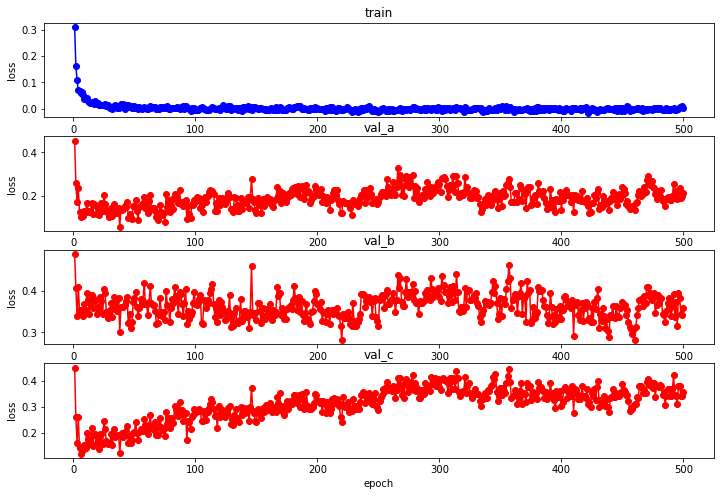

In [18]:
my_plot(np.arange(1, epoch+1), epoch_loss, epoch_loss_val_a, epoch_loss_val_b, epoch_loss_val_c, filename='Loss')   

use t-SNE to visualize features

In [19]:
from sklearn.manifold import TSNE

######### LSTM hyper-parameters
input_dim = 17 # 196  
conv1_dim = 128
conv2_dim = 128
lstm_dim = 128
layer_dim = 1
output_dim = 1
hidden1_dim = 128
hidden2_dim = 128

mode='trn' # 'trn' or 'val'

val_ds_b = MyDataset(val_datapath, data_len=len_min, interval=interval, epoch_percent=0, curriculum_type='b', transform=normalize)
val_dl = DataLoader(val_ds_b, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0, sampler=None)

trn_ds = MyDataset(trn_datapath, data_len=len_min, interval=interval, epoch_percent=0, curriculum_type='b', transform=normalize)
trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0, sampler=None)

if mode == 'val':
    dl=val_dl
elif mode == 'trn':
    dl=trn_dl

# initialize our implementation of ResNet
model = ConvLSTMClassifier(input_dim, conv1_dim, conv2_dim, lstm_dim, layer_dim, output_dim) # the same model but removed the last FC layer
# model = LSTMClassifier(input_dim, hidden1_dim, hidden2_dim, layer_dim, output_dim)
model = model.cuda()

model_file = './model/'+savename+'/last.pth'
model.load_state_dict(torch.load(model_file))
model.eval()
    
flag = 0
for x_val, y_val, sourcefile in dl: # I need x_val, y_val, frame_idx here for visualization
    x_val, y_val = [t.cuda() for t in (x_val, y_val)]
    out, out4inference = model(x_val) # (batch_size, 16)
    pred = torch.sigmoid(out)>0.5
    pred = pred.cpu().detach().numpy()
    feature = out4inference.cpu().detach().numpy()
    label = y_val.cpu().numpy()
    source = list(sourcefile)
    if flag == 0:
        features = feature
        labels = label
        preds = pred
        sources = source
        flag+=1
    else:
        features = np.concatenate((features,feature))
        labels = np.concatenate((labels,label))
        preds = np.concatenate((preds,pred))
        sources += source
        
    
print(features.shape, labels.shape, preds.shape, len(sources))

(36994, 128) (36994, 1) (36994, 1) 36994


In [20]:
setseed(0)
tsne = TSNE(n_components=2).fit_transform(features)

In [21]:
classname1=[]
for j in range(len(sources)):
    filename = Path(sources[j]).parent.parent.name
#     classname1.append(str(filename) + "@" + str(int(labels[j])))
    classname1.append(str(filename))
    
classname2=[]
for j in range(len(sources)):
    if labels[j] == 1:
        classname2.append("positive (label=1)")
    elif preds[j] == 1:
        classname2.append("possibly positive (label=0)")
    elif preds[j] == 0:
        classname2.append("possibly negative (label=0)")
    else:
        print("undefined class")
cm = plt.get_cmap('gist_rainbow')

keys = list(np.unique(classname1))
NUM_COLORS = len(keys)
values = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
colors_per_class1 = dict(zip(keys, values))

keys = list(np.unique(classname2))
NUM_COLORS = len(keys)
values = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
colors_per_class2 = dict(zip(keys, values))

In [22]:
def plot_tSNE(colors_per_class, classname, filename):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    # for every class, we'll add a scatter plot separately
    for label in reversed(list(colors_per_class.keys())):
        # find the samples of the current class in the data
        indices = [i for i, l in enumerate(classname) if l == label]

        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)

        # convert the class color to matplotlib format
    #     color = np.array(colors_per_class[label], dtype=np.float) / 255
        color = colors_per_class[label]

        # add a scatter plot with the corresponding color and label
        ax.scatter(current_tx, current_ty, color=color, label=label, s=10)

    # build a legend using the labels we set previously

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if filename:
        plt.savefig("./model/"+savename+"/"+filename+".pdf", format="pdf", bbox_inches="tight")
        
    # finally, show the plot
    plt.show()

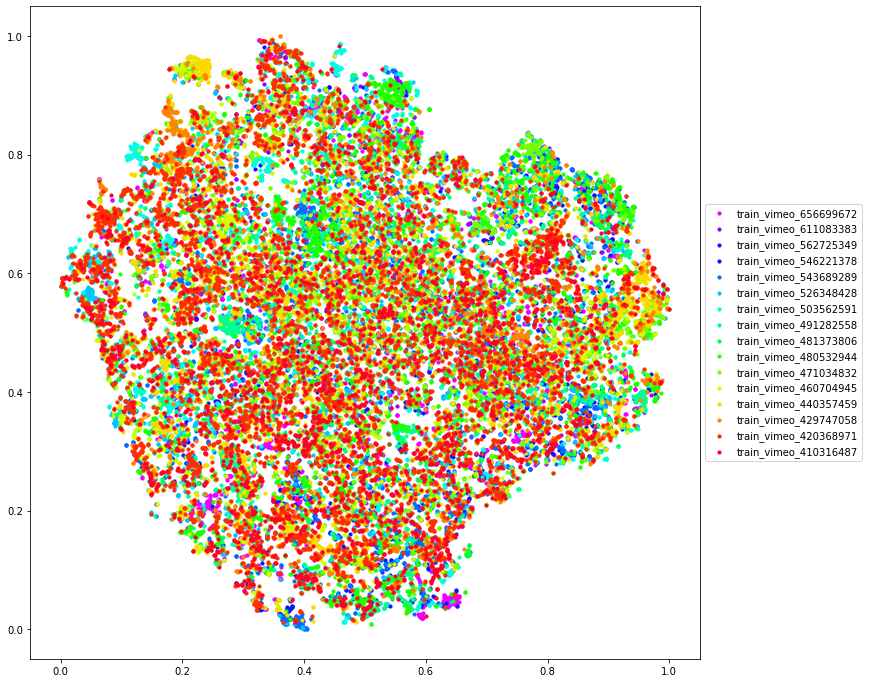

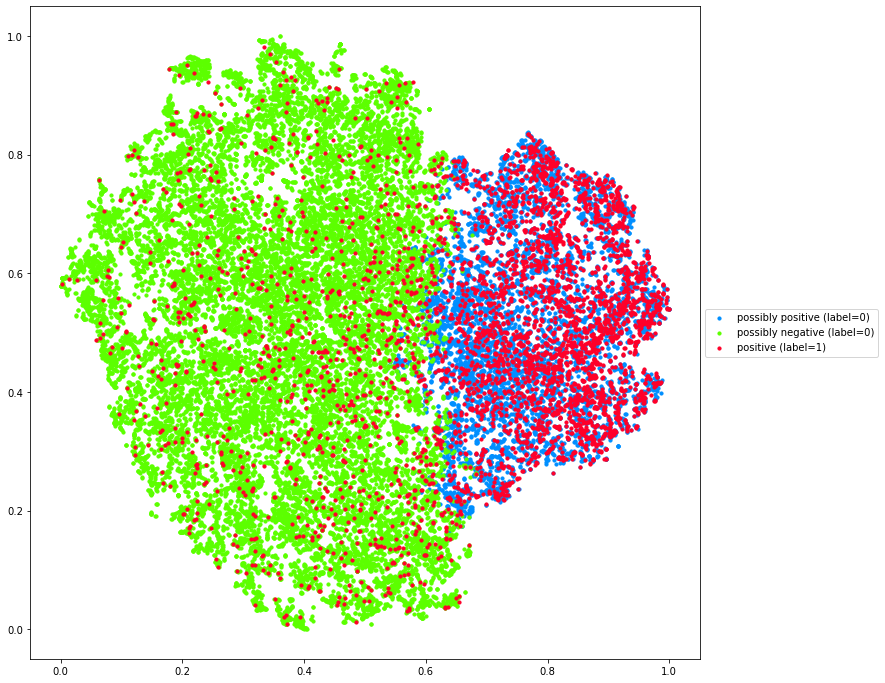

In [23]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

# initialize a matplotlib plot

plot_tSNE(colors_per_class1, classname1, filename=mode+'_tSNE1')
plot_tSNE(colors_per_class2, classname2, filename=mode+'_tSNE2')